In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')

FOLDERNAME = 'test_ml/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


##Подключение к устройству



In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


##Датасеты
Загрузка

In [4]:
import my_dataset

path_from = "drive/MyDrive/test_ml/dataset/train.zip"
path_to = "drive/MyDrive/test_ml/dataset/"

loaded_data = my_dataset.DataLoad(path_from, path_to)
loaded_data.data.head()

,filename,label
0,dog.4.jpg,dog
1,dog.40.jpg,dog
2,dog.400.jpg,dog
3,dog.4000.jpg,dog
4,dog.4001.jpg,dog


Разбиение датасета на 3 выборки: train = 80%, validation = 10%, test = 10%

In [5]:
x_train, x_valid, x_test = loaded_data.split_data()

print('Размер тренировочного набора данных', x_train.shape)
print('Размер валидационного набора данных', x_valid.shape)
print('Размер тестового набора данных', x_test.shape)

Размер тренировочного набора данных (15467, 2)
Размер валидационного набора данных (1933, 2)
Размер тестового набора данных (1934, 2)


Теперь нужно переиндексировать данные, т.к. они были разбиты и при попытке обращения к ним будет выскакивать одна и та же ошибка KeyError: 2

In [6]:
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

Аугментация

In [7]:
from my_dataset import CustomDataset

train_dataset = CustomDataset(data_frame=x_train, img_dir=path_to + "train/", transform=my_dataset.train_augmentation)
valid_dataset = CustomDataset(data_frame=x_valid, img_dir=path_to + "train/", transform=my_dataset.test_augmentation)
test_dataset = CustomDataset(data_frame=x_test, img_dir=path_to + "train/", transform=my_dataset.test_augmentation)

Разметка на батчи

In [8]:
from torch.utils.data import DataLoader

batch_size = 64 # размер батча
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Просмотр состояния картинки из датасета

In [9]:
print(len(train_dataset))
for image, label in train_dataset:
    print(image.shape)
    print(label.shape)
    break


15467
torch.Size([3, 128, 128])
torch.Size([1])


In [10]:
# 15467 / 64 = 242 (размер датасета / размер батча)
print(len(train_loader))
for image, label in train_loader:
    print(image.shape)
    print(label.shape)
    break

242
torch.Size([64, 3, 128, 128])
torch.Size([64, 1])


##Тренировка модели
Модель представляет из себя сверточную нейросеть.

In [11]:
import model
from train import train_model

net = model.Model().to(device)

loss_history, best_model, y_pred_valid = train_model(train_loader, valid_loader, net, epochs=8, device=device)


Epoch [0/8], Iteration 0, loss = 0.6939 acc = 0.4688
Epoch [0/8], Iteration 80, loss = 0.6613 acc = 0.6562
Epoch [0/8], Iteration 160, loss = 0.6026 acc = 0.7031
Epoch [0/8], Iteration 240, loss = 0.5919 acc = 0.7031
Epoch [1/8], Iteration 0, loss = 0.6501 acc = 0.6562
Epoch [1/8], Iteration 80, loss = 0.6968 acc = 0.6094
Epoch [1/8], Iteration 160, loss = 0.6158 acc = 0.7031
Epoch [1/8], Iteration 240, loss = 0.5962 acc = 0.7031
Epoch [2/8], Iteration 0, loss = 0.5562 acc = 0.7031
Epoch [2/8], Iteration 80, loss = 0.5694 acc = 0.7188
Epoch [2/8], Iteration 160, loss = 0.5503 acc = 0.7188
Epoch [2/8], Iteration 240, loss = 0.5029 acc = 0.7812
Epoch [3/8], Iteration 0, loss = 0.4790 acc = 0.7969
Epoch [3/8], Iteration 80, loss = 0.5474 acc = 0.6719
Epoch [3/8], Iteration 160, loss = 0.5249 acc = 0.7188
Epoch [3/8], Iteration 240, loss = 0.4894 acc = 0.7188
Epoch [4/8], Iteration 0, loss = 0.4306 acc = 0.8438
Epoch [4/8], Iteration 80, loss = 0.6380 acc = 0.7344
Epoch [4/8], Iteration 16

Работа с test набором

In [12]:
from train import test_model

y_pred_test = test_model(model=best_model, loader_test=test_loader, device=device)

##Оценка качества и вывод графиков
Оценка качества будет производиться по метрике f1.

In [13]:
import sklearn.metrics as metrics
import numpy as np

y_true_test = x_test['label']

y_predict_test = []
for y_pred in y_pred_test:
    y_predict_test.append('cat' if y_pred == 0 else 'dog')
Y_predict_test = np.array(y_predict_test).reshape(-1)

result_cats = metrics.f1_score(y_true_test, Y_predict_test, pos_label="cat")
result_dogs = metrics.f1_score(y_true_test, Y_predict_test, pos_label="dog")

print("Оценка качества F1 (коты):", result_cats)
print("Оценка качества F1 (собаки):", result_dogs)


Оценка качества F1 (коты): 0.8733986435568952
Оценка качества F1 (собаки): 0.7232289950576606


##Вывод графиков
Функция потерь

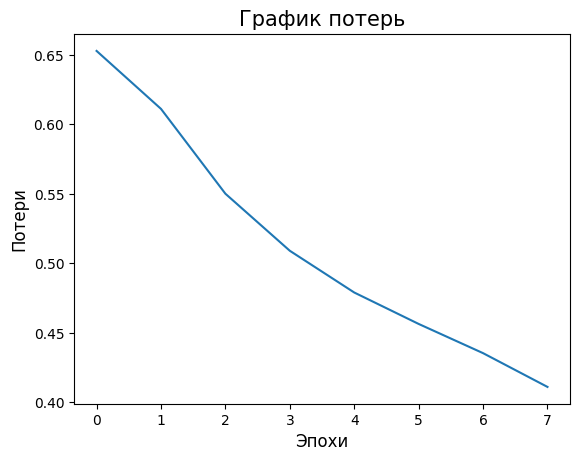

In [14]:
from matplotlib import pyplot as plt

#plt.figure(figsize=(20),dpi=200)

plt.title('График потерь',fontsize=15)
plt.xlabel('Эпохи',fontsize=12)
plt.ylabel('Потери',fontsize=12)
plt.plot(loss_history)

plt.show()

Confusion matrix для validation набора

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_valid = x_valid['label']

y_predict_valid = []
for y_pred in y_pred_valid:
    y_predict_valid.append('cat' if y_pred == 0 else 'dog')
y_predict_valid = np.array(y_predict_valid)

conf_matrix_valid = confusion_matrix(y_valid, y_predict_valid)
conf_matrix_labels_valid = pd.DataFrame(conf_matrix_valid, columns = ['cat', 'dog'], index = ['cat', 'dog'])
conf_matrix_labels_valid

,cat,dog
cat,1172,78
dog,242,441


Сonfusion matrix для test набора

In [16]:
y_test = x_test['label']

y_predict_test = []
for y_pred in y_pred_test:
    y_predict_test.append('cat' if y_pred == 0 else 'dog')
y_predict_test = np.array(y_predict_test)

conf_matrix_test = confusion_matrix(y_test, y_predict_test)
conf_matrix_labels_test = pd.DataFrame(conf_matrix_test, columns = ['cat', 'dog'], index = ['cat', 'dog'])
conf_matrix_labels_test

,cat,dog
cat,1159,91
dog,245,439
